<a href="https://colab.research.google.com/github/MagicHour/csc321_a1/blob/master/csc321_p1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CSC321H5 Project 1. Music Millenium Classification

**Deadline**: Thursday, Jan. 30, by 9pm

**Submission**: Submit a PDF export of the completed notebook. 

**Late Submission**: Please see the syllabus for the late submission criteria.

To celebrate the start of a new decade, we will build models to predict which
**century** a piece of music was released.  We will be using the "YearPredictionMSD Data Set"
based on the Million Song Dataset. The data is available to download from the UCI 
Machine Learning Repository. Here are some links about the data:

- https://archive.ics.uci.edu/ml/datasets/yearpredictionmsd
- http://millionsongdataset.com/pages/tasks-demos/#yearrecognition

## Question 1. Data

Start by setting up a Google Colab notebook in which to do your work.
If you are working with a partner, you might find this link helpful:

- https://colab.research.google.com/github/googlecolab/colabtools/blob/master/notebooks/colab-github-demo.ipynb

The recommended way to work together is pair coding, where you and your partner are sitting together and writing code together.

GREETINGS TRAVELLER


In [0]:
import pandas
import numpy as np
import matplotlib.pyplot as plt

Now that your notebook is set up, we can load the data into the notebook. The code below provides
two ways of loading the data: directly from the internet, or through mounting Google Drive.
The first method is easier but slower, and the second method is a bit involved at first, but
can save you time later on. You will need to mount Google Drive for later assignments, so we recommend
figuring how to do that now.

Here are some resources to help you get started:

- http://colab.research.google.com/notebooks/io.ipynb

In [0]:
import pandas
load_from_drive = False

if not load_from_drive:
  csv_path = "http://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip"
else:
  from google.colab import drive
  drive.mount('/content/gdrive')
  csv_path = '/content/drive/My Drive/csc321_a1/YearPredictionMSD.txt.zip' # TODO - UPDATE ME!

t_label = ["year"]
x_labels = ["var%d" % i for i in range(1, 91)]
df = pandas.read_csv(csv_path, names=t_label + x_labels)


Now that the data is loaded to your Colab notebook, you should be able to display the Pandas
DataFrame `df` as a table:

In [0]:
df

,year,var1,var2,var3,var4,var5,var6,var7,var8,var9,var10,var11,var12,var13,var14,var15,var16,var17,var18,var19,var20,var21,var22,var23,var24,var25,var26,var27,var28,var29,var30,var31,var32,var33,var34,var35,var36,var37,var38,var39,...,var51,var52,var53,var54,var55,var56,var57,var58,var59,var60,var61,var62,var63,var64,var65,var66,var67,var68,var69,var70,var71,var72,var73,var74,var75,var76,var77,var78,var79,var80,var81,var82,var83,var84,var85,var86,var87,var88,var89,var90
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,-2.46783,3.32136,-2.31521,10.20556,611.10913,951.08960,698.11428,408.98485,383.70912,326.51512,238.11327,251.42414,187.17351,100.42652,179.19498,-8.41558,-317.87038,95.86266,48.10259,-95.66303,-18.06215,1.96984,34.42438,11.72670,1.36790,7.79444,-0.36994,-133.67852,-83.26165,-37.29765,...,-25.38187,-3.90772,13.29258,41.55060,-7.26272,-21.00863,105.50848,64.29856,26.08481,-44.59110,-8.30657,7.93706,-10.73660,-95.44766,-82.03307,-35.59194,4.69525,70.95626,28.09139,6.02015,-37.13767,-41.12450,-8.40816,7.19877,-8.60176,-5.90857,-12.32437,14.68734,-54.32125,40.14786,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,4.59210,2.21920,0.34006,44.38997,2056.93836,605.40696,457.41175,777.15347,415.64880,746.47775,366.45320,317.82946,273.07917,141.75921,317.35269,19.48271,-65.25496,162.75145,135.00765,-96.28436,-86.87955,17.38087,45.90742,32.49908,-32.85429,45.10830,26.84939,-302.57328,-41.71932,-138.85034,...,28.55107,1.52298,70.99515,-43.63073,-42.55014,129.82848,79.95420,-87.14554,-45.75446,-65.82100,-43.90031,-19.45705,12.59163,-407.64130,42.91189,12.15850,-88.37882,42.25246,46.49209,-30.17747,45.98495,130.47892,13.88281,-4.00055,17.85965,-18.32138,-87.99109,14.37524,-22.70119,-58.81266,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,1.39518,2.73553,0.82804,7.46586,699.54544,1016.00954,594.06748,355.73663,507.39931,387.69910,287.15347,112.37152,161.68928,144.14353,199.29693,-4.24359,-297.00587,-148.36392,-7.94726,-18.71630,12.77542,-25.37725,9.71410,0.13843,26.79723,6.30760,28.70107,-74.89005,-289.19553,-166.26089,...,18.50939,16.97216,24.26629,-10.50788,-8.68412,54.75759,194.74034,7.95966,-18.22685,0.06463,-2.63069,26.02561,1.75729,-262.36917,-233.60089,-2.50502,-12.14279,81.37617,2.07554,-1.82381,183.65292,22.64797,-39.98887,43.37381,-31.56737,-4.88840,-36.53213,-23.94662,-84.19275,66.00518,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,-6.36304,6.63016,-3.35142,37.64085,2174.08189,697.43346,459.24587,742.78961,229.30783,387.89697,249.06662,245.89870,176.20527,98.82222,150.97286,78.49057,-62.00282,43.49659,-96.42719,-108.96608,14.22854,14.54178,-23.55608,-39.36953,-43.59209,20.83714,35.63919,-181.34947,-93.66614,-90.55616,...,4.56917,-37.32280,4.15159,12.24315,35.02697,-178.89573,82.46573,-20.49425,101.78577,-19.77808,-21.52657,3.36303,-11.63176,51.55411,-50.57576,-28.14755,-83.15795,-7.35260,-22.11505,1.18279,-122.70467,150.57360,24.37468,41.19821,-37.04318,-28.72986,162.19614,22.18309,-8.63509,85.23416,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,0.93609,1.60923,2.19223,47.32082,894.28471,809.86615,318.78559,435.04497,341.61467,334.30734,322.99589,190.61921,235.84715,96.89517,210.58870,5.60463,-199.63958,204.85812,-77.17695,-65.79741,-6.95097,-12.15262,-3.85410,20.68990,-20.30480,37.15045,11.20673,-124.09519,-295.98542,-33.31169,...,45.25506,10.42226,27.88782,-17.12676,-31.54772,-76.86293,41.17343,-138.32535,-53.96905,-21.30266,-24.87362,-2.46595,-4.0500

To set up our data for classification, we'll use the "year" field to represent
whether a song was released in the 20-th century. In our case `df["year"]` will be 1 if
the year was released after 2000, and 0 otherwise.

In [0]:
df["year"] = df["year"].map(lambda x: int(x > 2000))

### Part (a) -- 2 pts

The data set description text asks us to respect the below train/test split to
avoid the "producer effect". That is, we want to make sure that no song from a single artist
ends up in both the training and test set.

Explain why it would be problematic to have
some songs from an artist in the training set, and other songs from the same artist in the
test set. (Hint: Remember that we want our test accuracy to predict how well the model
will perform in practice on a song it hasn't learned about.)

In [0]:
df_train = df[:463715]
df_test = df[463715:]

# conver to numpy
train_xs = df_train[x_labels].to_numpy()
train_ts = df_train[t_label].to_numpy()
test_xs = df_test[x_labels].to_numpy()
test_ts = df_test[t_label].to_numpy()

# Write your explanation here
'''
This is because training based on a song from an artists also trains the model
for other songs from the same artist. This is because songs from the same artist
can be similar, so using the test data will essentially contain part of our
training data. Which would be problematic since we already learned from these
songs from the same artist.
'''

'\nThis is because training based on a song from an artists also trains the model\nfor other songs from the same artist. This is because songs from the same artist\ncan be similar, so using the test data will essentially contain part of our\ntraining data. Which would be problematic since we already learned from these\nsongs from the same artist.\n'

### Part (b) -- 1 pts

It can be beneficial to **normalize** the columns, so that each column (feature)
has the *same* mean and standard deviation.

In [0]:
feature_means = df_train.mean()[1:].to_numpy() # the [1:] removes the mean of the "year" field
feature_stds  = df_train.std()[1:].to_numpy()

train_norm_xs = (train_xs - feature_means) / feature_stds
test_norm_xs = (test_xs - feature_means) / feature_stds


Notice how in our code, we normalized the test set using the *training data means and standard deviations*.
This is *not* a bug.

Explain why it would be improper to compute and use test set means
and standard deviations. (Hint: Remember what we want to use the test accuracy to measure.)

In [0]:
# Write your explanation here

'''
If we use the test set means and standard deviations we are placing data within
the specified ranges of the test data, which maybe different from the training
data. If this is the case the model can be inaccurate as it is only trained for
data within the specified ranges from the training data.
'''

'\nIf we use the test set means and standard deviations we are placing data within\nthe specified ranges of the test data, which maybe different from the training\ndata. If this is the case the model can be inaccurate as it is only trained for\ndata within the specified ranges from the training data.\n'

### Part (c) -- 1 pts

Finally, we'll move some of the data in our training set into a validation set.

Explain why we should limit how many times we use the test set, and that we should use the validation
set during the model building process.

In [0]:
# shuffle the training set
reindex = np.random.permutation(len(train_xs))
train_xs = train_xs[reindex]
train_norm_xs = train_norm_xs[reindex]
train_ts = train_ts[reindex]

# use the first 50000 elements of `train_xs` as the validation set
train_xs, val_xs           = train_xs[50000:], train_xs[:50000]
train_norm_xs, val_norm_xs = train_norm_xs[50000:], train_norm_xs[:50000]
train_ts, val_ts           = train_ts[50000:], train_ts[:50000]

# Write your explanation here

'''
We should use the validation set during the model building process and limit
the usage of the test set because, hyperparameters will change depending on the
validation set. Whereas, the test set should be the unknown, that the model
has not seen yet. By using the test model we are essentially breaking this
rule that the test data should be unknown. Therefore, the test data should be
limited in use to keep it unknown.
'''


'\nWe should use the validation set during the model building process and limit\nthe usage of the test set because, hyperparameters will change depending on the\nvalidation set. Whereas, the test set should be the unknown, that the model\nhas not seen yet. By using the test model we are essentially breaking this\nrule that the test data should be unknown. Therefore, the test data should be\nlimited in use to keep it unknown.\n'

## Part 2. Classification

We will first build a *classification* model to perform decade classification.
These helper functions are written for you. All other code that you write in this
section should be vectorized whenever possible, and you will be penalized for 
not vectorizing your code.

In [0]:
def sigmoid(z):
  return 1 / (1 + np.exp(-z))
    
def cross_entropy(t, y):
  return -t * np.log(y) - (1 - t) * np.log(1 - y)

def cost(y, t):
  return np.mean(cross_entropy(t, y))

def get_accuracy(y, t):
  acc = 0
  N = 0
  for i in range(len(y)):
    N += 1
    if (y[i] >= 0.5 and t[i] == 1) or (y[i] < 0.5 and t[i] == 0):
      acc += 1
  return acc / N

### Part (a) -- 2 pts

Write a function `pred` that computes the prediction `y` based on weights `w` and bias `b`.

In [0]:
def pred(w, b, X):
  """
  Returns the prediction `y` of the target based on the weights `w` and scalar bias `b`.

  Preconditions: np.shape(w) == (90,)
                 type(b) == float
                 np.shape(X) = (N, 90) for some N

  >>> pred(np.zeros(90), 1, np.ones([2, 90]))
  array([0.73105858, 0.73105858]) # It's okay if your output differs in the last decimals
  """
  # Your code goes here
  w = w.reshape(len(w), 1)
  z = np.matmul(X, w) + b
  out = sigmoid(z)
  return out.flatten()

### Part (b) -- 3 pts

Write a function `derivative_cost` that computes and returns the gradients 
$\frac{\partial\mathcal{E}}{\partial {\bf w}}$ and
$\frac{\partial\mathcal{E}}{\partial b}$.

In [0]:
def derivative_cost(X, y, t):
  """
  Returns a tuple containing the gradients dEdw and dEdb.

  Precondition: np.shape(X) == (N, 90) for some N
                np.shape(y) == (N,)
                np.shape(t) == (N,)

  Postcondition: np.shape(dEdw) = (90,)
           type(dEdb) = float
  """
  # Your code goes here
  # return np.zeros(90), 0.
  N = len(y)
  y = y.reshape(len(y), 1)
  t = t.reshape(len(t), 1)
  y_t = y-t
  
  dEdw = (1/N)*(np.matmul(X.T, y_t))
  dEdb = (1/N)*np.sum(y_t)
  dEdw = dEdw.flatten()
  return (dEdw, dEdb)


### Part (c) -- 2 pts

We can check that our derivative is implemented correctly using the finite difference rule. In 1D, the
finite difference rule tells us that for small $h$, we should have

$$\frac{f(x+h) - f(x)}{h} \approx f'(x)$$

Prove to yourself (and your TA) that $\frac{\partial\mathcal{E}}{\partial b}$  is implement correctly
by comparing the result from `derivative_cost` with the value of `(pred(w, b + h, X) - pred(w, b, X)) / h`.
Justify your choice of `w`, `b`, and `X`.

In [0]:
# Your code goes here
#(cost(pred(w, b + h, X), t) - cost(pred(w, b, X), t)) / h
w = np.zeros(90)
b = -91
h = 0.000001
X = np.zeros([2, 90])
expected = np.e/((1+np.e)**2)
y = pred(w, b, X)
t = pred(w, b, X)
val1 = (cost(pred(w, b + h, X),t) - cost(pred(w, b, X), t)) / h
dEdw, dEdb = derivative_cost(X, y, y)
print(val1)

#print(w)
#print(calculated_w)
#print(np.sum(w-calculated_w))
#print(calculated_w.shape)
#print((dEdw, dEdb))
#TODO

'\nw = np.zeros(90)\nb = -91\nh = 0.000001\nX = np.zeros([2, 90])\nexpected = np.e/((1+np.e)**2)\ny = pred(w, b, X)\nt = pred(w, b, X)\nval1 = (pred(w, b + h, X) - pred(w, b, X)) / h\ndEdw, dEdb = derivative_cost(X, y, y)\nprint(val1)\n'

### Part (d) -- 2 pts

Prove to yourself (and your TA) that $\frac{\partial\mathcal{E}}{\partial {\bf w}}$  is implement correctly.

In [0]:
# Your code goes here. You might find this below code helpful: but it's
# up to you to figure out how/why, and how to modify the code
h = 0.000001
H = np.zeros(90)
H[0] = h
#TODO

### Part (e) -- 4 pts

Now that you have a gradient function that works, we can actually run gradient descent! Complete
the following code that will run stochastic: gradient descent training:

In [0]:
def run_gradient_descent(w0, b0, alpha=0.1, batch_size=100, max_iters=100):
  """Return the values of (w, b) after running gradient descent for max_iters.
  We use:
    - train_norm_xs and train_ts as the training set
    - val_norm_xs and val_ts as the test set
    - alpha as the learning rate
    - (w0, b0) as the initial values of (w, b)

  Precondition: np.shape(w0) == (90,)
                type(b0) == float
 
  Postcondition: np.shape(w) == (90,)
                 type(b) == float
  """
  global train_xs
  global train_norm_xs
  global train_ts
  train_xs_c = np.copy(train_xs)
  train_norm_xs_c = np.copy(train_norm_xs)
  train_ts_c = np.copy(train_ts)

  w = w0
  b = b0
  iter = 0

  line_graph = {'validation_accuracy':[], 'validation_cost':[]}
  x_axes = []

  while iter < max_iters:
    # shuffle the training set (there is code above for how to do this)
    reindex = np.random.permutation(len(train_xs_c))
    train_xs_c = train_xs_c[reindex]
    train_norm_xs_c = train_norm_xs_c[reindex]
    train_ts_c = train_ts_c[reindex]
    
    for i in range(0, len(train_norm_xs_c), batch_size): # iterate over each minibatch
      # minibatch that we are working with:
      X = train_norm_xs_c[i:(i + batch_size)]
      t = train_ts_c[i:(i + batch_size), 0]

      # since len(train_norm_xs) does not divide batch_size evenly, we will skip over
      # the "last" minibatch
      if np.shape(X)[0] != batch_size:
        continue

      # compute the prediction
      # y = ...
      y = pred(w, b, X)

      # update w and b
      # dw, db = ...
      # w = ...
      # b = ...
      dw, db = derivative_cost(X, y, t)
      w = w -alpha*dw
      b = b-alpha*db

      # increment the iteration count
      iter += 1

      # compute and plot the *validation* loss and accuracy
      #if (iter % 10 == 0):
        #train_cost = ...
        #val_y = ...
        #val_cost = ...
        #val_acc = ...
        #print("Iter %d. [Val Acc %.0f%%, Loss %f] [Train Loss %f]" % (
        #        iter, val_acc * 100, val_cost, train_cost))
      if (iter % 10 == 0):
        #The cost() function does not seem to work with 50,000 values
        #and it runs out of memory
        #as a result we will be using the first 1,000 validation values
        train_cost = cost(y,t)
        val_y = pred(w, b, val_norm_xs)
        val_cost = cost(pred(w,b,val_norm_xs[:1000]), val_ts[:1000])
        val_acc = get_accuracy(val_y[:1000],val_ts[:1000])
        print("Iter %d. [Val Acc %.0f%%, Loss %f] [Train Loss %f]" % (
                iter, val_acc * 100, val_cost, train_cost))
        line_graph['validation_cost'].append(val_cost)
        line_graph['validation_accuracy'].append(val_acc)
        x_axes.append(iter)

      if iter >= max_iters:
        break
  line_graph_df = pandas.DataFrame(data=line_graph, index=x_axes)
  line_graph_df.plot.line()
  return (w, b)

### Part (f) -- 2 pts

Call `run_gradient_descent` with the weights and biases all initialized to zero.
Show that if `alpha` is too small, then convergence is slow.
Also, show that if `alpha` is too large, then we do not converge at all!

---Run with alpha = 0.001---
---Run with alpha = 10---
Iter 10. [Val Acc 68%, Loss 0.886382] [Train Loss 0.790303]
Iter 20. [Val Acc 63%, Loss 0.950002] [Train Loss 0.689810]
Iter 30. [Val Acc 72%, Loss 0.886873] [Train Loss 0.658374]
Iter 40. [Val Acc 69%, Loss 0.907578] [Train Loss 0.701382]
Iter 50. [Val Acc 71%, Loss 1.020943] [Train Loss 0.489636]
Iter 60. [Val Acc 72%, Loss 0.979622] [Train Loss 0.811534]
Iter 70. [Val Acc 73%, Loss 0.984054] [Train Loss 0.631031]
Iter 80. [Val Acc 71%, Loss 0.995629] [Train Loss 0.745499]
Iter 90. [Val Acc 70%, Loss 1.013129] [Train Loss 0.867281]
Iter 100. [Val Acc 72%, Loss 1.041143] [Train Loss 0.593757]


(array([ 1.44738070e+00, -8.25267796e-01, -2.19458081e-01, -5.42805423e-02,
        -3.91739945e-04, -7.86407166e-01,  8.71040062e-02, -2.62183096e-01,
        -2.55564430e-01,  1.29239163e-01, -1.83523414e-01,  6.60758973e-02,
         1.97900161e-01,  9.55197955e-02, -1.80258708e-01,  3.92714379e-01,
         4.57821840e-02,  5.79041330e-01,  1.59142901e-01,  4.11732021e-01,
        -7.37150838e-04,  1.08555491e-01,  5.31916620e-01,  4.23181001e-01,
        -2.65897286e-01, -7.84236910e-02, -6.70243238e-02, -9.78051052e-02,
         4.55658071e-02,  5.45463927e-02, -1.62608754e-01, -4.26136735e-02,
        -1.00430103e-01, -2.58491607e-03, -1.57497291e-01, -1.85369700e-01,
        -1.38923917e-01, -9.46230278e-02,  2.56624186e-01, -1.05694159e-01,
        -2.11942610e-01,  4.41379449e-02, -2.13102351e-01,  3.78525527e-04,
         3.02961020e-02,  9.84056240e-02,  3.33195085e-02, -1.63573673e-01,
         1.18739716e-03, -8.20485612e-02, -2.24193621e-02, -1.49345055e-01,
         8.6

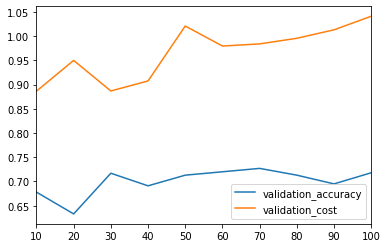

In [0]:
w0 = np.zeros(90)
b0 = 0.
# Write your code here
print('---Run with alpha = 0.001---')
#run_gradient_descent(w0,b0,alpha=0.001)

#Notice the validation accuracy does not change

print('---Run with alpha = 10---') 
#run_gradient_descent(w0,b0,alpha=1)

#Notice the validation accuracies jump from place to place and does not converge.
run_gradient_descent(w0,b0,alpha=1)

### Part (g) -- 2 pts

Find the optimial value of ${\bf w}$ and $b$ using your code. Explain how you chose
the learning rate $\alpha$ and the batch size.

Iter 10. [Val Acc 67%, Loss 0.693143] [Train Loss 0.693065]
Iter 20. [Val Acc 67%, Loss 0.693136] [Train Loss 0.692959]
Iter 30. [Val Acc 67%, Loss 0.693135] [Train Loss 0.693024]
Iter 40. [Val Acc 68%, Loss 0.693134] [Train Loss 0.692866]
Iter 50. [Val Acc 68%, Loss 0.693130] [Train Loss 0.692801]
Iter 60. [Val Acc 70%, Loss 0.693126] [Train Loss 0.692888]
Iter 70. [Val Acc 70%, Loss 0.693124] [Train Loss 0.692659]
Iter 80. [Val Acc 70%, Loss 0.693122] [Train Loss 0.692709]
Iter 90. [Val Acc 69%, Loss 0.693118] [Train Loss 0.693031]
Iter 100. [Val Acc 69%, Loss 0.693113] [Train Loss 0.692800]
Iter 10. [Val Acc 64%, Loss 0.693109] [Train Loss 0.692558]
Iter 20. [Val Acc 66%, Loss 0.693084] [Train Loss 0.692019]
Iter 30. [Val Acc 66%, Loss 0.693056] [Train Loss 0.691399]
Iter 40. [Val Acc 65%, Loss 0.693042] [Train Loss 0.690873]
Iter 50. [Val Acc 67%, Loss 0.693034] [Train Loss 0.688416]
Iter 60. [Val Acc 68%, Loss 0.693016] [Train Loss 0.686220]
Iter 70. [Val Acc 68%, Loss 0.692997] [

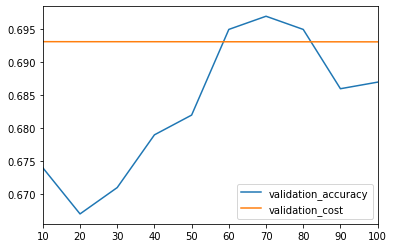

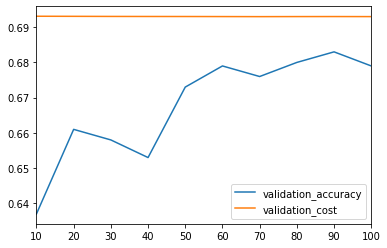

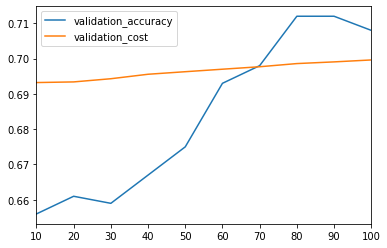

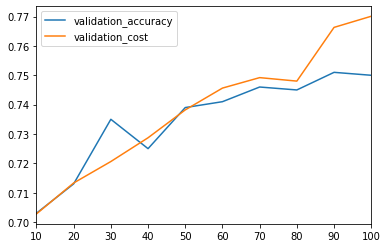

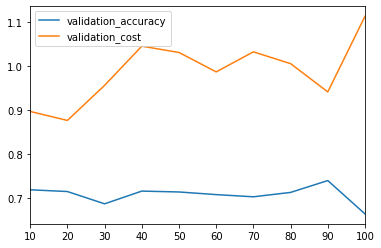

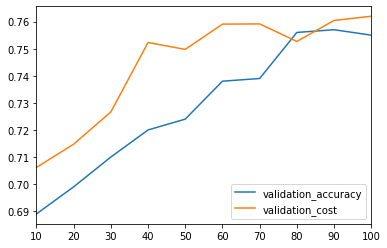

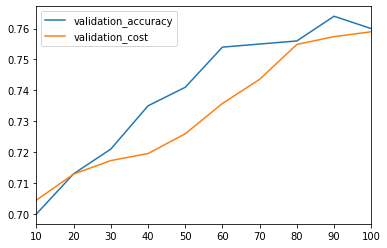

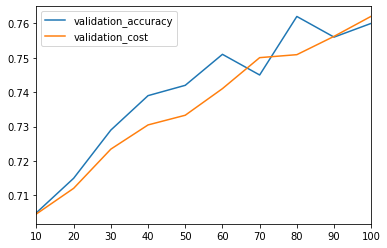

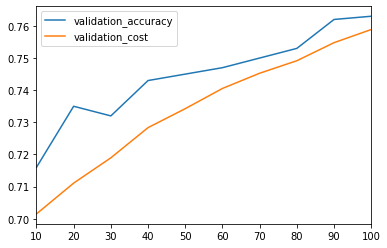

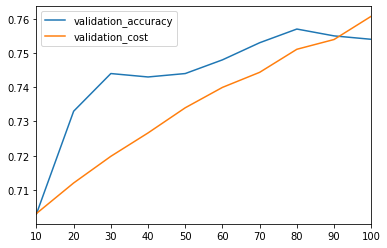

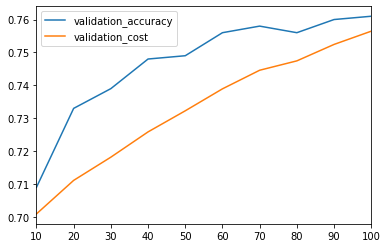

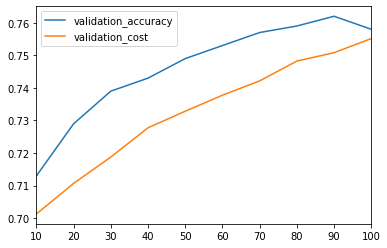

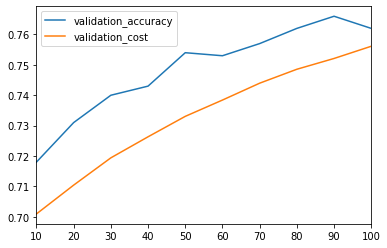

In [0]:
w0 = np.zeros(90)
b0 = 0.
# Write your code here
'''
The learning rate was chosen by starting at a small value and incrementally
multiplying the size by 10 each time to find the largest validation accuracy.
'''

a = 0.0001
max_acc = float('-inf')
best_a = None

while(a <= 1):
  
  cur_w, cur_b = run_gradient_descent(w0,b0,alpha=a)
  cur_y_val = pred(cur_w, cur_b, val_norm_xs)

  if(get_accuracy(cur_y_val, val_ts) > max_acc):
    max_acc = get_accuracy(cur_y_val, val_ts)
    best_a = a
  a = a*10

'''
A similar approach was done here as with the learning rate.
'''

b = 100
max_acc = float('-inf')
best_b = 413715

while(b <= 10000):
  
  cur_w, cur_b = run_gradient_descent(w0,b0,alpha=best_a, batch_size=b)
  cur_y_val = pred(cur_w, cur_b, val_norm_xs)

  if(get_accuracy(cur_y_val, val_ts) > max_acc):
    min_acc = get_accuracy(cur_y_val, val_ts)
    best_b = b
  b = b*2

w, b = run_gradient_descent(w0,b0,alpha=best_a, batch_size=best_b)

#print(str(best_a) + '|' + str(best_b))


### Part (h) -- 4 pts

Using the values of `w` and `b` from part (g), compute your training accuracy, validation accuracy,
and test accuracy. Are there any differences between those three values? If so, why?

In [0]:
# Write your code here

#get predictions
y_train = pred(w,b,train_norm_xs)
y_val = pred(w,b,val_norm_xs)
y_test = pred(w,b,test_norm_xs)

#get acc
print('train accuracy = '+str(get_accuracy(y_train, train_ts)))
print('validation accuracy = '+str(get_accuracy(y_val, val_ts)))
print('test accuracy = '+str(get_accuracy(y_test, test_ts)))

train accuracy = 0.7192632609405025
validation accuracy = 0.71966
test accuracy = 0.7101685066821616


### Part (i) -- 4 pts

Writing a classifier like this is instructive, and helps you understand what happens when
we train a model. However, in practice, we rarely write model building and training code
from scratch. Instead, we typically use one of the well-tested libraries available in a package.

Use `sklearn.linear_model.LogisticRegression` to build a linear classifier, and make predictions about the test set. Start by reading the
[API documentation here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).

Compute the training, validation and test accuracy of this model.

In [0]:
import sklearn.linear_model as lin

#init
model = lin.LogisticRegression()
model.fit(train_norm_xs, train_ts.flatten())
w = model.coef_.T
b = model.intercept_

#get predictions
y_train = pred(w,b,train_norm_xs)
y_val = pred(w,b,val_norm_xs)
y_test = pred(w,b,test_norm_xs)

#get acc
print('train accuracy = '+str(get_accuracy(y_train, train_ts)))
print('validation accuracy = '+str(get_accuracy(y_val, val_ts)))
print('test accuracy = '+str(get_accuracy(y_test, test_ts)))

train accuracy = 0.73290308545738
validation accuracy = 0.73136
test accuracy = 0.7267673833042805


## Part 3. Nearest Neighbour

We will compare the nearest neighbour model with the model we built in the earlier parts.

To make predictions for a new data point using k-nearest neighbour, we will need to:

1. Compute the distance from this new data point to every element in the training set
2. Select the top $k$ closest neighbour in the training set
3. Find the most common label among those neighbours

We'll use the validation test to select $k$. That is, we'll select the $k$ that gives the highest
validation accuracy.

Since we have a fairly large data set, computing the distance between a point in the validation
set and all points in the training set will require more RAM than Google Colab provides.
To make the comptuations tractable, we will:

1. Use only a subset of the training set (only the first 100,000 elements)
2. Use only a subset of the validation set (only the first 1000 elements)
3. We will use the **cosine similarity** rather than Euclidean distance. We will also pre-scale
   each element in training set and the validation set to be a unit vector, so that computing
   the cosine similarity is equivalent to computing the dot product. To see this, recall that 
   $$cos(\theta) = \frac{v \cdot w}{||v|| ||w||}$$. But if both ||v|| and ||w|| are zero, then
   only the dot product remains.

In [0]:
# we'll need to take the first 100000 element of `train_norm_xs`
# and scale each of its rows to be unit length
xs = train_norm_xs[:100000]
# compute the norms:
norms = np.linalg.norm(xs, axis=1)
# divide the xs by the norms. Because of numpy's broadcasting rules, we need to
# transpose the matrices a couple of times:
#   https://docs.scipy.org/doc/numpy/user/basics.broadcasting.html
xs = (xs.T / norms).T

### Part (a) -- 1 pt

Create a numpy matrix `val_xs` that contains the first 1000 elements of `val_norm_xs`, scaled
so that each of its rows is unit length. Follow the code above.

In [0]:
# val_xs = ...
val_xs = val_norm_xs[:1000]

norms = np.linalg.norm(val_xs, axis=1)


val_xs = (val_xs.T / norms).T

### Part (b) -- 1 pt

Our goal now is to compute the validation accuracy for a choice of $k$. This will
require computing the distance between each song in the training set and each
song in the validation set.

This is actually quite straightforward, and can be done using one matrix
computation operation!

Compute all the distances between elements of `xs` and those of `val_xs`
using a single call to `np.dot`.

In [0]:
#val_distances = np.dot ...
val_distances = np.dot(xs, val_xs.T)

#print(val_distances[:, [1,2]])
print(val_distances[:, 1])

#e = enumerate(val_distances[:, [1,2]])


#print(enumerate(val_distances[:, [1,2]]))

#print(sorted(val_distances[:, [1,2]]))

holder = np.apply_along_axis(lambda x: sorted(enumerate(x), key=lambda r: r[1], reverse=True), 0, val_distances[:, np.arange(0, 1000)])
res = [index for (index, dist) in holder[:10]]
print (res.shape())


#neighbours = sorted(enumerate(val_distances[:, 1]), key=lambda r: r[1], reverse=True)
#neighbour_indices = [index for (index, dist) in neighbours[:10]]
#print (neighbour_indices)

[ 0.44719678 -0.02985854  0.05473874 ...  0.01423046  0.10180492
  0.13516908]


AttributeError: ignored

### Part (c) -- 3 pt

Now that we have the distance pairs, we can use the matrix `val_distances`
to find the set of neighbours for each point in our validation set and 

Find the validation accuracy assuming that we use $k = 10$. You may
use the below helper function if you want, and the `get_accuracy` helper
from the last section.

You might also find it helpful to do parts (c) and (d) together.

In [0]:
def get_nearest_neighbours(i, k=10):
  """Return the indices of the top k-element of `xs` that are closests to
  element `i` of the validation set `val_xs`.
  """
  # sort the element of the training set by distance to the i-th
  # element of val_xs
  neighbours = sorted(enumerate(val_distances[:, i]),
                      key=lambda r: r[1],
                      reverse=True)
  # obtain the top k closest index and return it
  neighbour_indices = [index for (index, dist) in neighbours[:k]]
  return neighbour_indices 

def get_train_ts(indices):
  """Return the labels of the corresponding elements in the training set `xs`.
  Note that `xs` is the first 100,000 elements of `train_xs`, so we can
  simply index `train_ts`.
  """
  return train_ts[indices]

r = (np.array(res)).reshape(1000, 10).astype(int)
print (r.shape)
#print (r)
#print (np.arange(0, 1000))
#print(get_nearest_neighbours(np.arange(0, 1)))
nearest_neighbours_classes = get_train_ts(r.reshape(10000)).reshape(1000, 10)
print (nearest_neighbours_classes)
#nearest = np.apply_along_axis(get_nearest_neighbours, 1, np.arange(0, 1000).reshape(1000, 1))

#print(nearest)
#np.vectorize(get_train_ts)
#print(get_nearest_neighbours(100))

(1000, 10)
[[1 1 1 ... 0 0 1]
 [1 0 1 ... 1 1 1]
 [0 0 1 ... 0 1 0]
 ...
 [1 0 1 ... 1 1 0]
 [0 1 0 ... 0 1 0]
 [1 0 1 ... 1 1 0]]


### Part (d) -- 2 pts

Compute the validation accuracy for $k = 50, 100, and 1000$.
Which $k$ provides the best results? In other words, which kNN model would you deploy?

In [0]:
# Write your code and solution here

### Part (e) -- 4 pt

Compute the test accuracy for the $k$ that you chose in the previous part.
Use only a sample of 1000 elements from the test set to keep the problem tractable.

In [0]:
# Write your code and solution here